In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')
%matplotlib inline

from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

np.random.seed(42)

from sklearn.model_selection import train_test_split
import lightgbm as lgbm
from sklearn.metrics import confusion_matrix, accuracy_score

# 1. 데이터 로드

In [2]:
train=pd.read_csv('input/train.csv', index_col=0) #인덱스 col=0도 check!
test=pd.read_csv('input/test_x.csv', index_col=0)
submission=pd.read_csv('input/sample_submission.csv', index_col=0)  

In [ ]:
train.shape, test.shape, submission.shape
train.head(3)
test.head(3)
submission.head(3)

# 2. EDA & 전처리

In [ ]:
df = pd.concat([train, test])
df.shape

In [ ]:
train.info

## Missing Value

In [ ]:
train.isnull().sum().sum()
test.isnull().sum().sum()

## Target 분포

In [ ]:
f, ax = plt.subplots(1, 2, figsize=(10, 4))

train['voted'].value_counts().plot.pie(autopct='%1.1f%%', ax=ax[0], shadow=True)
sns.countplot('voted', data=train, ax=ax[1])

plt.show()

# 균일

## 컬럼 분류

In [3]:
data = []

for f in train.columns:
    dtl = ''
    if f == 'voted':
        gubun = 'target'
    elif 'Q' in f:
        dtl = f[1]
        if 'A' in f:
            gubun = 'Q_A'
        if 'E' in f:
            gubun = 'Q_E'
    elif 'tp' in f:           
        gubun = 'tp'            
    elif 'wf' in f:           
        gubun = 'wf'
    elif 'wr' in f:           
        gubun = 'wr'    
    else:
        gubun = 'cat'
        
    f_dict = {
        'col':f,
        'gbn':gubun,
        'dtl':dtl
    }
            
    data.append(f_dict)
    
meta = pd.DataFrame(data, columns =['col', 'gbn', 'dtl'])
meta.set_index('col', inplace=True)
meta

,gbn,dtl
col,,
QaA,Q_A,a
QaE,Q_E,a
QbA,Q_A,b
QbE,Q_E,b
QcA,Q_A,c
...,...,...
wr_09,wr,
wr_10,wr,
wr_11,wr,


### Q_A

In [4]:
Q_A = meta[meta.gbn=='Q_A'].index
train[Q_A].describe()
train[Q_A].head(3)

,QaA,QbA,QcA,QdA,QeA,QfA,QgA,QhA,QiA,QjA,QkA,QlA,QmA,QnA,QoA,QpA,QqA,QrA,QsA,QtA
count,45532.000000,45532.000000,45532.000000,45532.000000,45532.000000,45532.000000,45532.000000,45532.000000,45532.000000,45532.000000,45532.000000,45532.000000,45532.000000,45532.000000,45532.000000,45532.000000,45532.000000,45532.000000,45532.000000,45532.000000
mean,2.129535,2.904463,3.662347,1.749078,2.317952,2.168145,2.560595,2.317952,3.157691,3.575529,3.813933,4.325727,3.509620,2.632896,3.217232,3.071752,2.840464,2.823487,3.432948,3.225687
std,1.196952,1.566142,1.431494,1.043625,1.369205,1.348653,1.510600,1.460813,1.481740,1.361220,1.372551,1.146992,1.375134,1.473022,1.476414,1.489744,1.404342,1.424383,1.374938,1.521603
min,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000
25%,1.000000,1.000000,2.000000,1.000000,1.000000,1.000000,1.000000,1.000000,2.000000,2.000000,3.000000,4.000000,2.000000,1.000000,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000
50%,2.000000,3.000000,4.000000,1.000000,2.000000,2.000000,2.000000,2.000000,3.000000,4.000000,4.000000,5.000000,4.000000,2.000000,4.000000,3.000000,3.000000,3.000000,4.000000,4.000000
75%,3.000000,4.000000,5.000000,2.000000,3.000000,3.000000,4.000000,4.000000,5.000000,5.000000,5.000000,5.000000,5.000000,4.000000,5.000000,4.000000,4.000000,4.000000,5.000000,5.000000
max,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000


,QaA,QbA,QcA,QdA,QeA,QfA,QgA,QhA,QiA,QjA,QkA,QlA,QmA,QnA,QoA,QpA,QqA,QrA,QsA,QtA
index,,,,,,,,,,,,,,,,,,,,
0,3.0,4.0,5.0,1.0,2.0,5.0,2.0,4.0,5.0,4.0,4.0,4.0,2.0,5.0,2.0,2.0,2.0,2.0,2.0,1.0
1,5.0,5.0,3.0,5.0,1.0,3.0,1.0,1.0,5.0,3.0,5.0,4.0,1.0,5.0,1.0,5.0,5.0,1.0,4.0,1.0
2,4.0,1.0,1.0,4.0,5.0,1.0,4.0,1.0,3.0,2.0,5.0,5.0,2.0,4.0,2.0,1.0,5.0,4.0,1.0,1.0


### Q_A 1/5 count

In [5]:
# Q_A: 1~5 1/5 극단값 선택한 count 추출
train['Q1'] = 0
train['Q3'] = 0
train['Q5'] = 0

test['Q1'] = 0
test['Q3'] = 0
test['Q5'] = 0

In [6]:
%%time
for f in Q_A:
    for i, v in enumerate(train[f]):
        if v == 1:
            train.loc[i, 'Q1'] = train.loc[i, 'Q1']+1
        elif v == 3:
            train.loc[i, 'Q3'] = train.loc[i, 'Q3']+1
        elif v == 5:
            train.loc[i, 'Q5'] = train.loc[i, 'Q5']+1            

Wall time: 2min 37s


In [7]:
%%time
for f in Q_A:
    for i, v in enumerate(test[f]):
        if v == 1:
            test.loc[i, 'Q1'] = test.loc[i, 'Q1']+1
        elif v == 3:
            test.loc[i, 'Q3'] = test.loc[i, 'Q3']+1            
        elif v == 5:
            test.loc[i, 'Q5'] = test.loc[i, 'Q5']+1                        

Wall time: 34.3 s


In [ ]:
colQ_As = Q_A.tolist()
colQ_As.extend(['Q1','Q3','Q5', 'voted'])

corr_Q_A = train[colQ_As].corr()

mask = np.zeros_like(corr_Q_A, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True
plt.figure(figsize=(18, 12))
plt.title('colQ_As', fontsize=18)

sns.heatmap(corr_Q_A, mask=mask, annot=True,cmap='RdYlGn', linewidths=0.2, annot_kws={'size':10})
plt.show()

In [ ]:
corr_Q_A['voted'].abs().sort_values(ascending=False)

### Q_E

In [8]:
Q_E = meta[meta.gbn == 'Q_E'].index
train[Q_E].describe()
train[Q_E].head()

,QaE,QbE,QcE,QdE,QeE,QfE,QgE,QhE,QiE,QjE,QkE,QlE,QmE,QnE,QoE,QpE,QqE,QrE,QsE,QtE
count,4.553200e+04,4.553200e+04,45532.000000,4.553200e+04,4.553200e+04,4.553200e+04,4.553200e+04,4.553200e+04,4.553200e+04,4.553200e+04,4.553200e+04,4.553200e+04,4.553200e+04,45532.000000,4.553200e+04,4.553200e+04,4.553200e+04,4.553200e+04,4.553200e+04,4.553200e+04
mean,9.453570e+02,2.189589e+03,1484.294518,1.490672e+03,1.899292e+03,1.850650e+03,1.284608e+03,4.584272e+03,4.068434e+03,2.576363e+03,2.038986e+03,3.741018e+03,2.050287e+03,959.880502,1.435762e+03,1.633479e+03,1.154352e+03,2.470808e+03,1.164117e+03,2.240057e+03
std,1.307565e+04,3.351027e+04,8977.664318,1.092260e+04,1.670765e+04,7.608236e+04,9.756584e+03,5.020265e+05,1.141738e+05,5.411432e+04,3.069164e+04,3.663672e+05,7.530787e+04,5869.964127,1.084997e+04,2.600221e+04,2.250689e+04,1.482890e+05,7.433515e+03,6.730924e+04
min,2.500000e+01,2.500000e+01,25.000000,2.600000e+01,2.500000e+01,2.500000e+01,2.500000e+01,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,2.500000e+01,2.500000e+01,25.000000,0.000000e+00,0.000000e+00,0.000000e+00,2.500000e+01,2.500000e+01,2.500000e+01
25%,4.040000e+02,8.750000e+02,651.000000,6.790000e+02,8.340000e+02,5.040000e+02,5.490000e+02,1.077000e+03,1.259000e+03,9.020000e+02,8.590000e+02,8.060000e+02,6.500000e+02,428.000000,6.380000e+02,7.060000e+02,4.610000e+02,7.940000e+02,5.270000e+02,7.330000e+02
50%,5.570000e+02,1.218000e+03,899.000000,9.310000e+02,1.154000e+03,7.120000e+02,7.720000e+02,1.464000e+03,1.800000e+03,1.260000e+03,1.178000e+03,1.125000e+03,9.060000e+02,596.000000,8.830000e+02,9.700000e+02,6.520000e+02,1.117000e+03,7.470000e+02,1.020000e+03
75%,8.270000e+02,1.838000e+03,1335.000000,1.355000e+03,1.656000e+03,1.078000e+03,1.150000e+03,2.090000e+03,2.761000e+03,1.899000e+03,1.721000e+03,1.649000e+03,1.342000e+03,891.000000,1.300000e+03,1.409000e+03,9.820000e+02,1.664000e+03,1.124000e+03,1.526000e+03
max,2.413960e+06,5.580395e+06,871557.000000,1.552821e+06,1.919926e+06,1.176370e+07,1.068252e+06,1.070860e+08,1.703586e+07,9.910006e+06,4.824953e+06,7.754351e+07,1.410832e+07,606694.000000,1.309739e+06,4.650742e+06,4.277510e+06,3.159328e+07,1.286581e+06,1.155650e+07


,QaE,QbE,QcE,QdE,QeE,QfE,QgE,QhE,QiE,QjE,QkE,QlE,QmE,QnE,QoE,QpE,QqE,QrE,QsE,QtE
index,,,,,,,,,,,,,,,,,,,,
0,363,1370,997,1024,1577,539,586,1095,1142,1287,883,851,851,816,579,924,366,876,633,1115
1,647,1313,3387,2969,4320,2190,826,4082,1867,1264,2943,3927,4329,1828,1214,2414,1356,3039,4304,1346
2,1623,1480,1021,3374,1333,531,1167,1016,2653,1569,998,2547,918,2153,1304,1131,937,1327,1170,1409
3,504,2311,992,3245,357,1519,159,2275,2809,5614,3219,1296,9046,1216,1169,23868,581,8830,2392,1312
4,927,707,556,1062,1014,628,991,1259,1153,1388,740,1181,547,575,754,1140,323,1070,583,1889


In [ ]:
for f in Q_E:
    g = sns.FacetGrid(train, col='voted').map(sns.distplot, f)

In [ ]:
for f in Q_E:
    print(f, train[f].min(), train[f].max())

In [ ]:
colQ_Es = Q_E.tolist()
colQ_Es.extend(['voted'])

corr_Q_E = train[colQ_Es].corr()

mask = np.zeros_like(corr_Q_E, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True
plt.figure(figsize=(18, 12))
plt.title('colQ_ES', fontsize=18)

sns.heatmap(corr_Q_E, mask=mask, annot=True,cmap='RdYlGn', linewidths=0.2, annot_kws={'size':10})
plt.show()

#### skew

In [ ]:
for f in Q_E:
    train[f] = np.log1p(train[f])
    test[f] = np.log1p(test[f])

### tp

In [9]:
# 0~7 
tp = meta[meta.gbn=='tp'].index
train[tp].describe()
train[tp].head(3)

,tp01,tp02,tp03,tp04,tp05,tp06,tp07,tp08,tp09,tp10
count,45532.000000,45532.000000,45532.000000,45532.000000,45532.000000,45532.000000,45532.000000,45532.000000,45532.000000,45532.000000
mean,3.017241,2.621189,1.768712,3.041246,1.335918,2.472217,2.031099,3.507226,2.277497,4.317996
std,2.007713,1.897081,1.685069,2.037278,1.452544,2.000658,1.785824,1.971456,1.848783,1.722793
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,1.000000,1.000000,0.000000,1.000000,0.000000,1.000000,1.000000,2.000000,1.000000,3.000000
50%,3.000000,2.000000,1.000000,3.000000,1.000000,2.000000,2.000000,4.000000,2.000000,5.000000
75%,5.000000,4.000000,3.000000,5.000000,2.000000,4.000000,3.000000,5.000000,4.000000,6.000000
max,7.000000,7.000000,7.000000,7.000000,7.000000,7.000000,7.000000,7.000000,7.000000,7.000000


,tp01,tp02,tp03,tp04,tp05,tp06,tp07,tp08,tp09,tp10
index,,,,,,,,,,
0,2,2,2,1,2,1,7,4,4,3
1,1,1,0,0,1,2,3,4,0,4
2,2,3,1,5,3,4,2,6,1,3


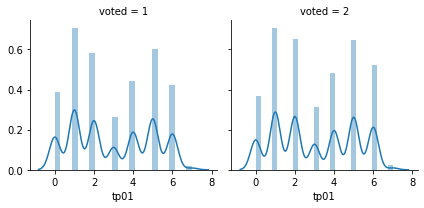

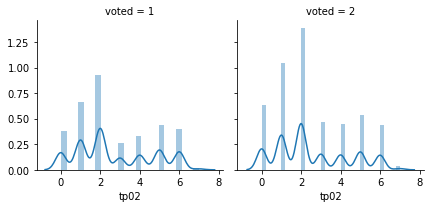

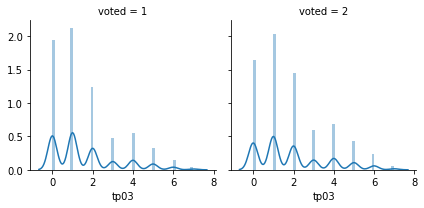

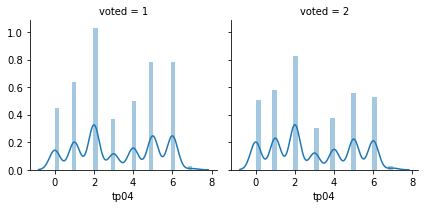

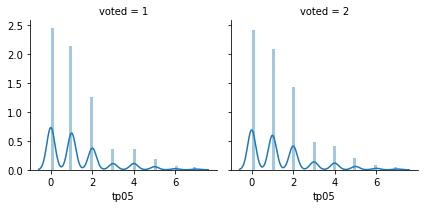

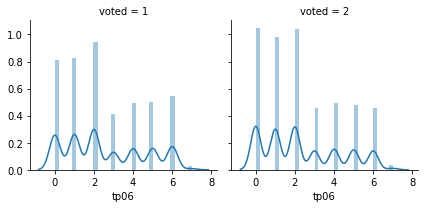

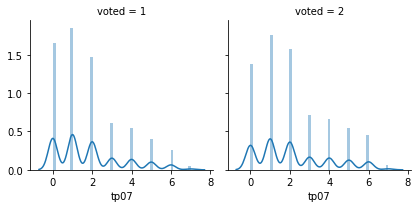

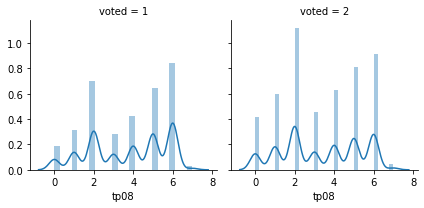

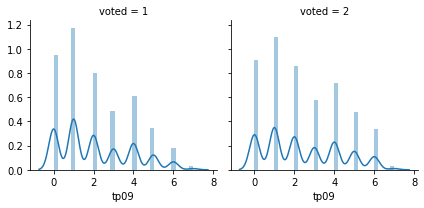

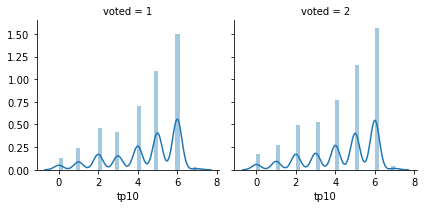

In [10]:
for f in tp:
    g = sns.FacetGrid(train, col='voted').map(sns.distplot, f)

<Figure size 1296x864 with 0 Axes>

Text(0.5, 1.0, 'col_tpS')

<AxesSubplot:title={'center':'col_tpS'}>

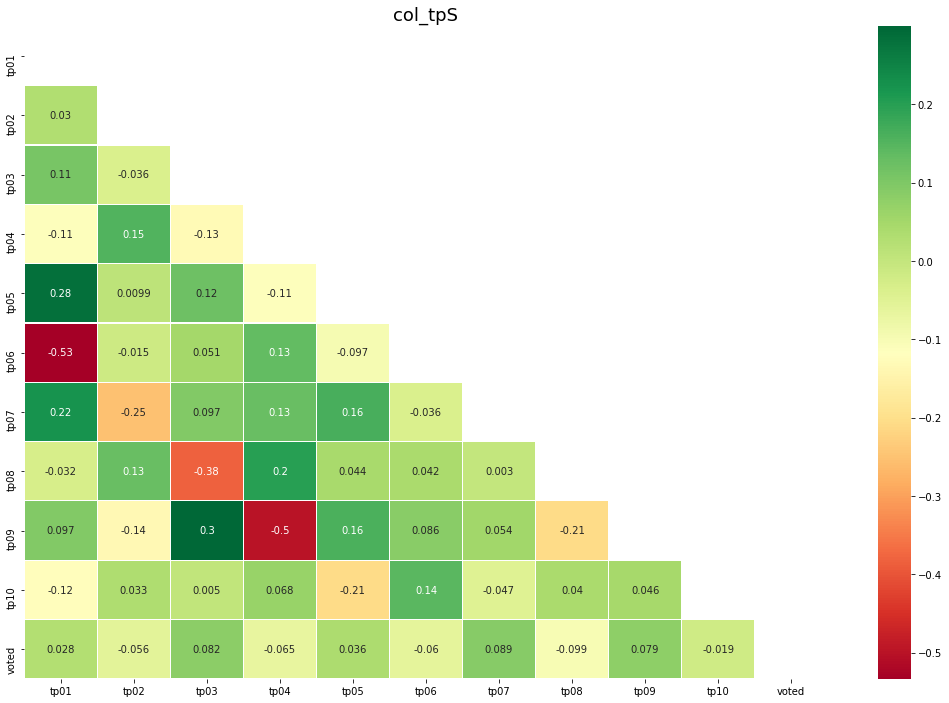

In [11]:
col_tps = tp.tolist()
col_tps.extend(['voted'])

corr_tp = train[col_tps].corr()

mask = np.zeros_like(corr_tp, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True
plt.figure(figsize=(18, 12))
plt.title('col_tpS', fontsize=18)

sns.heatmap(corr_tp, mask=mask, annot=True,cmap='RdYlGn', linewidths=0.2, annot_kws={'size':10})
plt.show()

In [10]:
# tp: 1,7 극단값 선택한 count 추출, 4 중간값 선택 count 
train['tp17'] = 0
train['tp4'] = 0

test['tp17'] = 0
test['tp4'] = 0

In [11]:
%%time
for f in tp:
    for i, v in enumerate(train[f]):
        if (v == 1 | v == 7):
            train.loc[i, 'tp17'] = train.loc[i, 'tp17']+1
        if v == 4:
            train.loc[i, 'tp4'] = train.loc[i, 'tp4']+1            

Wall time: 16.1 s


In [12]:
%%time
for f in tp:
    for i, v in enumerate(test[f]):
        if (v == 1 | v == 7):
            test.loc[i, 'tp17'] = test.loc[i, 'tp17']+1
        if v == 4:
            test.loc[i, 'tp4'] = test.loc[i, 'tp4']+1            

Wall time: 3.55 s


#### 극단값 중간값

In [ ]:
train.columns.values

In [13]:
train['QA15tp17'] = train['Q1'] + train['Q5'] + train['tp17']
train['QA3tp4'] = train['Q3'] + train['tp4']

In [14]:
test['QA15tp17'] = test['Q1'] + test['Q5'] + test['tp17']
test['QA3tp4'] = test['Q3'] + test['tp4']

#### ratio

In [ ]:
pd.options.display.max_columns = 100
train

In [15]:
train['Q1'] = train['Q1'] /20
train['Q3'] = train['Q3'] /20
train['Q5'] = train['Q5'] /20

train['tp17'] = train['tp17'] /10
train['tp4'] = train['tp4'] /10

train['QA15tp17'] = train['QA15tp17'] /30
train['QA3tp4'] = train['QA3tp4'] /30

In [16]:
test['Q1'] = test['Q1'] /20
test['Q3'] = test['Q3'] /20
test['Q5'] = test['Q5'] /20

test['tp17'] = test['tp17'] /10
test['tp4'] = test['tp4'] /10

test['QA15tp17'] = test['QA15tp17'] /30
test['QA3tp4'] = test['QA3tp4'] /30

In [ ]:
meta.gbn.unique()

In [ ]:
# 0/1
wf = meta[meta.gbn=='wf'].index
train[wf].describe()
train[wf].head(3)

In [ ]:
# 0/1
wr = meta[meta.gbn=='wr'].index
train[wr].describe()
train[wr].head(3)

In [ ]:
corr = train.corr()
corr['voted'].abs().sort_values(ascending=False)[:20]
corr['voted'].abs().sort_values(ascending=False)[60:]

### CAT EDA

In [ ]:
meta[meta.gbn == 'cat']

In [ ]:
train['voted0'] = train['voted']
train.loc[train.voted0 == 2, 'voted0'] = 0
train.voted0.value_counts()

#### age_group

In [17]:
def cat_summary(col):
    print('colname: ', col)
    print(train[col].value_counts())
    return pd.crosstab(train[col], train['voted0'], margins=True).style.background_gradient(cmap='summer_r')

In [18]:
def cat_plot(col):
    print('colname: ', col)
    return train[[col, 'voted0']].groupby([col], as_index=True).mean().sort_values(by='voted0', ascending=False).plot.bar()

In [ ]:
for f in meta[meta.gbn == 'cat'].index:
    cat_summary(f)

In [ ]:
for f in meta[meta.gbn == 'cat'].index:
    cat_plot(f)

## Target Encoding

### age_group

In [20]:
train['age_group_int'] = train['age_group'].str.replace('s','').astype('int')
test['age_group_int'] = test['age_group'].str.replace('s','').astype('int')

In [21]:
train['age_group_n_rows'] = train['age_group_int'].map(train.groupby('age_group_int').size())
test['age_group_n_rows'] = test['age_group_int'].map(test.groupby('age_group_int').size())

In [22]:
age_group_mean = train.groupby('age_group_int')['voted'].mean()
train['age_group_mean'] = train['age_group_int'].map(age_group_mean)
test['age_group_mean'] = test['age_group_int'].map(age_group_mean)

In [23]:
# train['voted'].mean() = 1.5468242115435298
def smoothing(n_rows, target_mean): 
    return (target_mean*n_rows + 1.5468242115435298*0.8) / (n_rows + 0.8)

In [24]:
train['age_group_mean_smoothing'] = train.apply(lambda x:smoothing(x['age_group_n_rows'], x['age_group_mean']), axis=1)
test['age_group_mean_smoothing'] = test.apply(lambda x:smoothing(x['age_group_n_rows'], x['age_group_mean']), axis=1)

In [25]:
train.drop(['age_group_int','age_group_mean', 'age_group_n_rows'], axis=1, inplace=True)
test.drop(['age_group_int','age_group_mean', 'age_group_n_rows'], axis=1, inplace=True)

## Outlier

In [ ]:
test.familysize.max(), test.familysize.mean(), train[train.familysize < 30]['familysize'].mean()

In [ ]:
train[train.familysize > 20][['voted', 'familysize']]

In [26]:
train.loc[train[train.familysize > 25].index, 'familysize'] = 2.6

In [ ]:
train['familysize'].value_counts()

## 인코딩

In [ ]:
#age_group, gender, race, religion
#train['age_group'] = train['age_group'].str.replace('s','').astype('int')
train['gender']= pd.factorize(train['gender'])[0]
train['race']=pd.factorize(train['race'])[0]
train['religion']=pd.factorize(train['religion'])[0]

#test['age_group'] = test['age_group'].str.replace('s','').astype('int')
test['gender']=pd.factorize(test['gender'])[0]
test['race']=pd.factorize(test['race'])[0]
test['religion']=pd.factorize(test['religion'])[0]

### One-hot

In [ ]:
train = pd.get_dummies(train, columns=['age_group', 'education', 'engnat', 'gender', 'hand',
       'married', 'race', 'religion', 'tp01', 'tp02', 'tp03', 'tp04', 'tp05',
       'tp06', 'tp07', 'tp08', 'tp09', 'tp10', 'urban', 'wf_01',
       'wf_02', 'wf_03', 'wr_01', 'wr_02', 'wr_03', 'wr_04', 'wr_05', 'wr_06',
       'wr_07', 'wr_08', 'wr_09', 'wr_10', 'wr_11', 'wr_12', 'wr_13'])
train

In [ ]:
test = pd.get_dummies(test, columns=['age_group', 'education', 'engnat', 'gender', 'hand',
       'married', 'race', 'religion', 'tp01', 'tp02', 'tp03', 'tp04', 'tp05',
       'tp06', 'tp07', 'tp08', 'tp09', 'tp10', 'urban', 'wf_01',
       'wf_02', 'wf_03', 'wr_01', 'wr_02', 'wr_03', 'wr_04', 'wr_05', 'wr_06',
       'wr_07', 'wr_08', 'wr_09', 'wr_10', 'wr_11', 'wr_12', 'wr_13'])
test

In [ ]:
train.shape, test.shape
train.columns.values
test.columns.values

# 3. 모델 학습

In [27]:
from pycaret.classification import *

In [28]:
import gc
gc.collect()

32

In [29]:
col_cat = meta[(meta.gbn == 'Q_A') | (meta.gbn == 'cat')].index.values.tolist()
col_cat

['QaA',
 'QbA',
 'QcA',
 'QdA',
 'QeA',
 'QfA',
 'QgA',
 'QhA',
 'QiA',
 'QjA',
 'QkA',
 'QlA',
 'QmA',
 'QnA',
 'QoA',
 'QpA',
 'QqA',
 'QrA',
 'QsA',
 'QtA',
 'age_group',
 'education',
 'engnat',
 'familysize',
 'gender',
 'hand',
 'married',
 'race',
 'religion',
 'urban']

In [30]:
col_numeric = ['Q1','Q3','Q5', 'tp17','tp4', 'QA15tp17', 'QA3tp4']
col_numeric

['Q1', 'Q3', 'Q5', 'tp17', 'tp4', 'QA15tp17', 'QA3tp4']

In [ ]:
#col_ignore = meta[(meta.gbn == 'wf') | (meta.gbn == 'wr')].index.values.tolist()
#col_ignore = meta[(meta.gbn == 'Q_E')].index.values.tolist()
col_ignore = []

In [32]:
%%time
clf = setup(session_id=42, 
            data = train, target = 'voted', polynomial_features=True
          , categorical_features=col_cat
            ,numeric_features=col_numeric
            #,ignore_features =['voted0']
            ,feature_selection=True
            ,use_gpu=True
           )

Setup Succesfully Completed!


,Description,Value
0,session_id,42
1,Target Type,Binary
2,Label Encoded,"1: 0, 2: 1"
3,Original Data,"(45532, 85)"
4,Missing Values,False
5,Numeric Features,28
6,Categorical Features,56
7,Ordinal Features,False
8,High Cardinality Features,False
9,High Cardinality Method,None


Wall time: 47.9 s


In [33]:
#best_3 = compare_models(sort = 'AUC', n_select = 3)
best_5 = compare_models(sort = 'AUC', n_select = 5)

,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,TT (Sec)
0,Gradient Boosting Classifier,0.6932,0.7620,0.6412,0.7602,0.6956,0.3908,0.3966,26.8274
1,CatBoost Classifier,0.6929,0.7620,0.6585,0.7495,0.7010,0.3881,0.3916,20.4391
2,Light Gradient Boosting Machine,0.6897,0.7590,0.6456,0.7518,0.6946,0.3828,0.3875,1.4174
3,Linear Discriminant Analysis,0.6877,0.7589,0.6602,0.7405,0.6980,0.3768,0.3796,1.2204
4,Ada Boost Classifier,0.6891,0.7556,0.6547,0.7458,0.6972,0.3806,0.3841,6.6486
5,Extra Trees Classifier,0.6875,0.7540,0.6335,0.7556,0.6891,0.3799,0.3860,3.3702
6,Extreme Gradient Boosting,0.6710,0.7389,0.6642,0.7142,0.6882,0.3410,0.3421,14.1790
7,Random Forest Classifier,0.6567,0.7144,0.6051,0.7222,0.6584,0.3188,0.3239,0.4029
8,Decision Tree Classifier,0.6069,0.6035,0.6402,0.6407,0.6404,0.2070,0.2070,2.0816
9,Naive Bayes,0.5372,0.5277,0.8999,0.5121,0.6364,-0.0004,-0.0053,0.1694


In [34]:
blended = blend_models(estimator_list = best_5, fold = 10, method = 'soft', optimize='AUC')

,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
0,0.6906,0.7636,0.6351,0.7599,0.6919,0.3861,0.3924
1,0.7000,0.7775,0.6710,0.7536,0.7099,0.4015,0.4044
2,0.6773,0.7502,0.6385,0.7361,0.6838,0.3576,0.3614
3,0.6945,0.7603,0.6392,0.7635,0.6958,0.3938,0.4001
4,0.6859,0.7570,0.6449,0.7461,0.6918,0.3750,0.3791
5,0.6894,0.7570,0.6456,0.7513,0.6944,0.3823,0.3869
6,0.6961,0.7690,0.6485,0.7603,0.7000,0.3960,0.4011
7,0.7144,0.7806,0.6851,0.7677,0.7240,0.4301,0.4331
8,0.7038,0.7690,0.6693,0.7604,0.7119,0.4097,0.4132
9,0.6905,0.7635,0.6585,0.7457,0.6994,0.3829,0.3861


In [35]:
pred_holdout = predict_model(blended)

,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
0,Voting Classifier,0.6953,0.7652,0.6546,0.7555,0.7015,0.3935,0.3978


In [36]:
final_model = finalize_model(blended)

In [37]:
predictions = predict_model(final_model, data = test)

# 4. 예측

In [38]:
submission['voted'] = predictions['Score']

# 5. 제출

In [39]:
submission.to_csv('output/20201001-1-O_-log1p+dynamic.csv')